In [1]:
%matplotlib inline


Audio Resampling
================

토치 오디오의 Resampling의 사용법을 알아보자

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.0+cu117
0.13.0+cu117


In [12]:
math.log(8)

2.0794415416798357

In [13]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

pd.set_option('display.max_rows', None)
# pandas의 옵션을 설정
# 설정된 옵션을 확인할때는 get_option
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

Resampling Overview
-------------------

To resample an audio waveform from one freqeuncy to another, you can use
:py:func:`torchaudio.transforms.Resample` or
:py:func:`torchaudio.functional.resample`.
``transforms.Resample`` precomputes and caches the kernel used for resampling,
while ``functional.resample`` computes it on the fly, so using
``torchaudio.transforms.Resample`` will result in a speedup when resampling
multiple waveforms using the same parameters (see Benchmarking section).

Both resampling methods use `bandlimited sinc
interpolation <https://ccrma.stanford.edu/~jos/resample/>`__ to compute
signal values at arbitrary time steps. The implementation involves
convolution, so we can take advantage of GPU / multithreading for
performance improvements.

<div class="alert alert-info"><h4>Note</h4><p>When using resampling in multiple subprocesses, such as data loading
   with multiple worker processes, your application might create more
   threads than your system can handle efficiently.
   Setting ``torch.set_num_threads(1)`` might help in this case.</p></div>

Because a finite number of samples can only represent a finite number of
frequencies, resampling does not produce perfect results, and a variety
of parameters can be used to control for its quality and computational
speed. We demonstrate these properties through resampling a logarithmic
sine sweep, which is a sine wave that increases exponentially in
frequency over time.

The spectrograms below show the frequency representation of the signal,
where the x-axis corresponds to the frequency of the original
waveform (in log scale), y-axis the frequency of the
plotted waveform, and color intensity the amplitude.




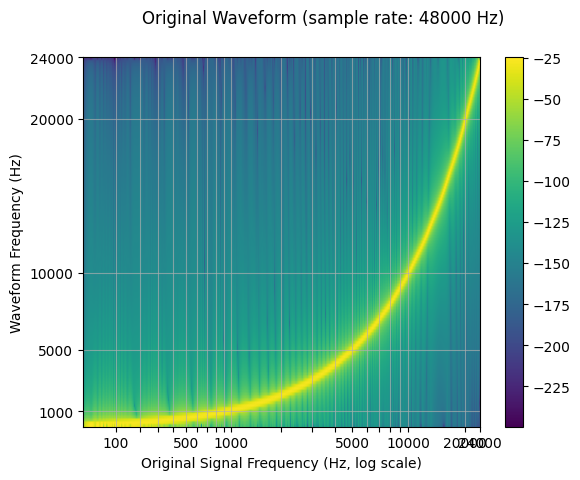

In [14]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

Now we resample (downsample) it.

We see that in the spectrogram of the resampled waveform, there is an
artifact, which was not present in the original waveform.



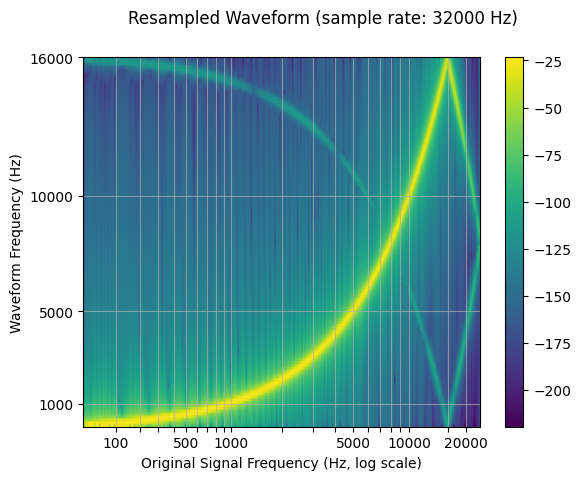

In [15]:
resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

Controling resampling quality with parameters
---------------------------------------------

Lowpass filter width
~~~~~~~~~~~~~~~~~~~~

Because the filter used for interpolation extends infinitely, the
``lowpass_filter_width`` parameter is used to control for the width of
the filter to use to window the interpolation. It is also referred to as
the number of zero crossings, since the interpolation passes through
zero at every time unit. Using a larger ``lowpass_filter_width``
provides a sharper, more precise filter, but is more computationally
expensive.




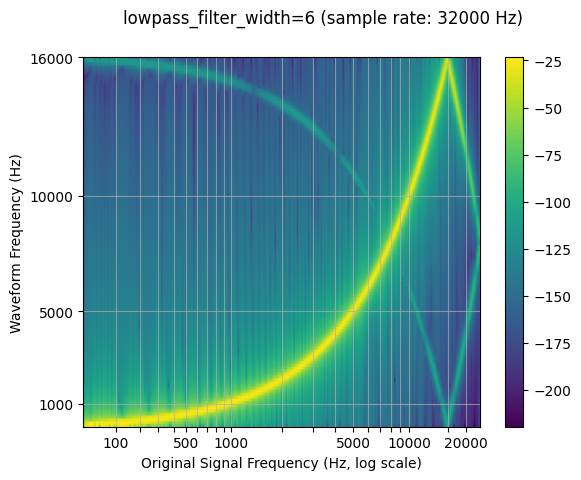

In [16]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

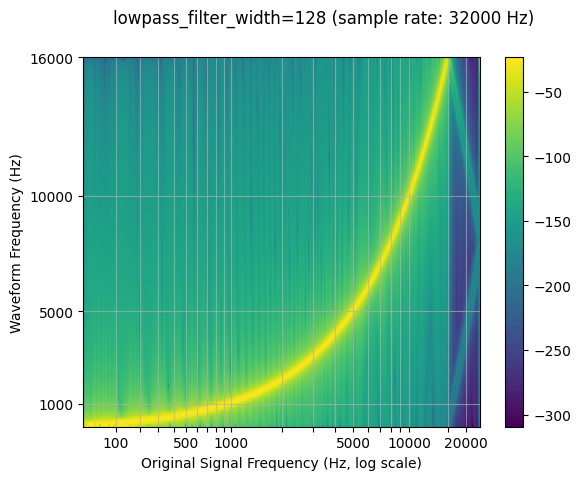

In [17]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

Rolloff
~~~~~~~

The ``rolloff`` parameter is represented as a fraction of the Nyquist
frequency, which is the maximal frequency representable by a given
finite sample rate. ``rolloff`` determines the lowpass filter cutoff and
controls the degree of aliasing, which takes place when frequencies
higher than the Nyquist are mapped to lower frequencies. A lower rolloff
will therefore reduce the amount of aliasing, but it will also reduce
some of the higher frequencies.




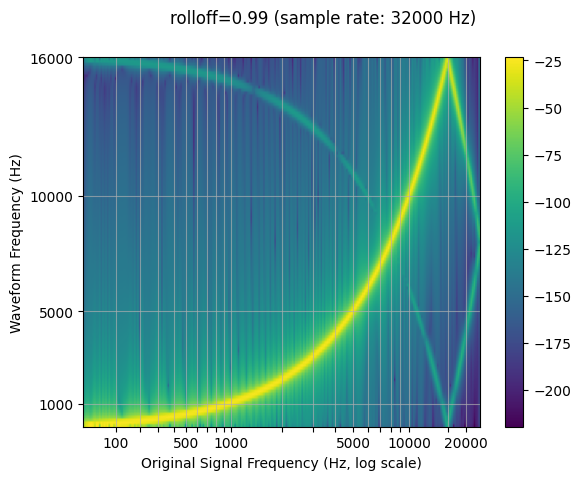

In [18]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

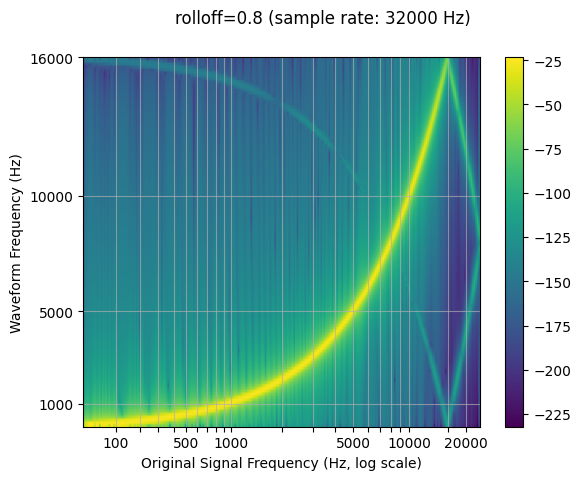

In [19]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

Window function
~~~~~~~~~~~~~~~

By default, ``torchaudio``’s resample uses the Hann window filter, which is
a weighted cosine function. It additionally supports the Kaiser window,
which is a near optimal window function that contains an additional
``beta`` parameter that allows for the design of the smoothness of the
filter and width of impulse. This can be controlled using the
``resampling_method`` parameter.




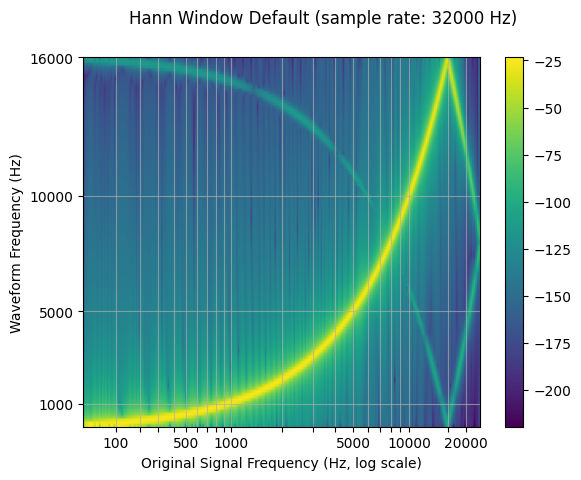

In [20]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

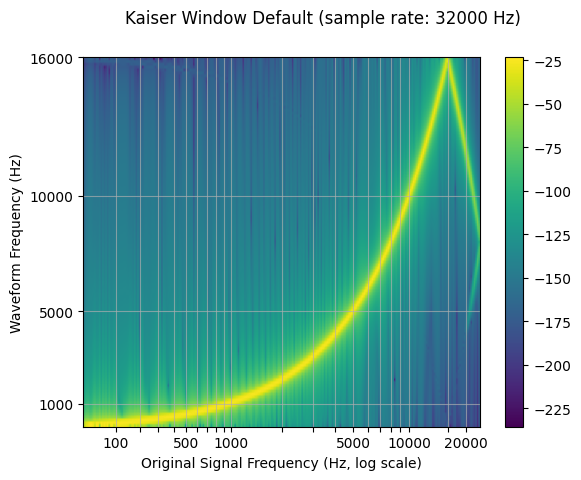

In [21]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

Comparison against librosa
--------------------------

``torchaudio``’s resample function can be used to produce results similar to
that of librosa (resampy)’s kaiser window resampling, with some noise




In [22]:
sample_rate = 48000
resample_rate = 32000

kaiser_best
~~~~~~~~~~~




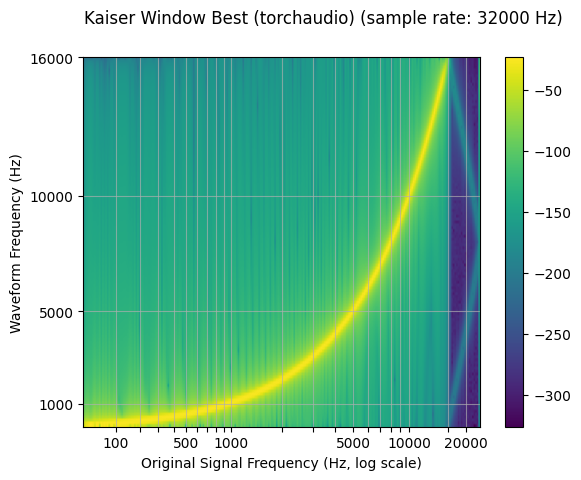

In [23]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

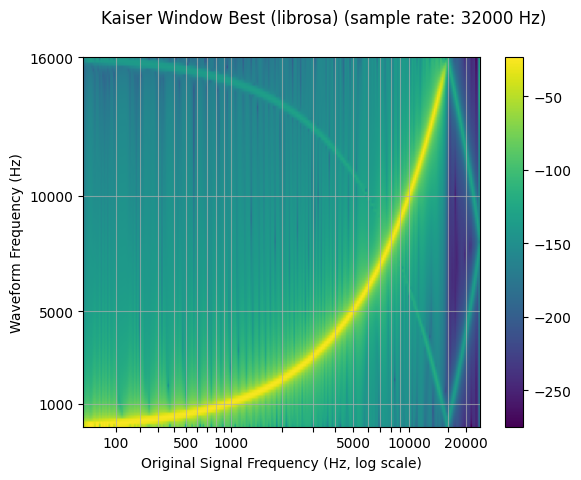

In [24]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_best")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

In [25]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

torchaudio and librosa kaiser best MSE: 0.0013004566355607607


kaiser_fast
~~~~~~~~~~~




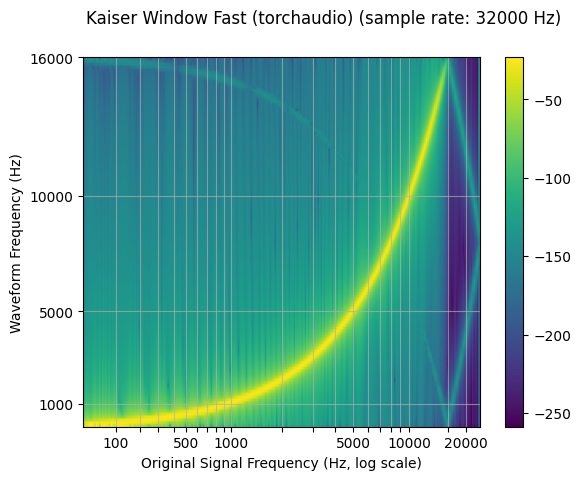

In [26]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

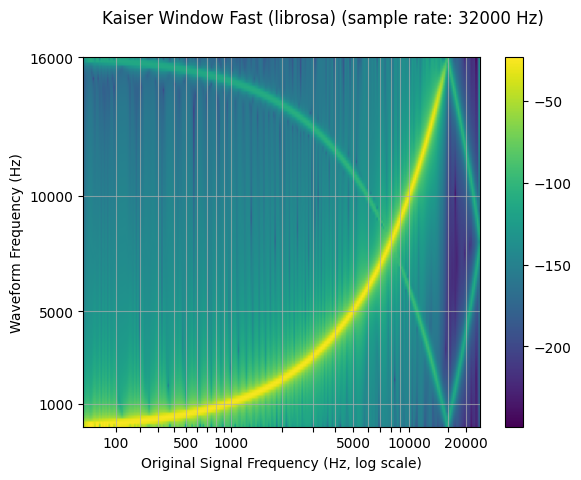

In [27]:
librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), orig_sr=sample_rate, target_sr=resample_rate, res_type="kaiser_fast")
).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

In [28]:
mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)

torchaudio and librosa kaiser fast MSE: 0.00025679812518532064


Performance Benchmarking
------------------------

Below are benchmarks for downsampling and upsampling waveforms between
two pairs of sampling rates. We demonstrate the performance implications
that the ``lowpass_filter_wdith``, window type, and sample rates can
have. Additionally, we provide a comparison against ``librosa``\ ’s
``kaiser_best`` and ``kaiser_fast`` using their corresponding parameters
in ``torchaudio``.

To elaborate on the results:

- a larger ``lowpass_filter_width`` results in a larger resampling kernel,
  and therefore increases computation time for both the kernel computation
  and convolution
- using ``kaiser_window`` results in longer computation times than the default
  ``sinc_interpolation`` because it is more complex to compute the intermediate
  window values - a large GCD between the sample and resample rate will result
  in a simplification that allows for a smaller kernel and faster kernel computation.




In [29]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interpolation",
    beta=None,
    librosa_type=None,
    iters=5,
):
    if method == "functional":
        begin = time.monotonic()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.monotonic()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "librosa":
        waveform_np = waveform.squeeze().numpy()
        begin = time.monotonic()
        for _ in range(iters):
            librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=resample_rate, res_type=librosa_type)
        elapsed = time.monotonic() - begin
        return elapsed / iters

In [30]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
    times, rows = [], []
    sample_rate = configs[label][0]
    resample_rate = configs[label][1]
    waveform = get_sine_sweep(sample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_best")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_best")

    # kaiser fast
    lib_time = benchmark_resample("librosa", waveform, sample_rate, resample_rate, librosa_type="kaiser_fast")
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    times.append([1000 * lib_time, 1000 * f_time, 1000 * t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"], df.columns])

    print(f"torchaudio: {torchaudio.__version__}")
    print(f"librosa: {librosa.__version__}")
    display(df.round(2))

torchaudio: 0.13.0+cu117
librosa: 0.9.2


downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN       2.80       0.81
sinc (width 16)                                   NaN       1.45       0.70
kaiser_best                                     31.64       2.32       0.42
kaiser_fast                                      8.56       1.56       0.35

torchaudio: 0.13.0+cu117
librosa: 0.9.2


downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN       3.86       2.95
sinc (width 16)                                NaN       1.14       0.80
kaiser_best                                  10.26       2.55       1.90
kaiser_fast                                   3.76       0.84       0.50

torchaudio: 0.13.0+cu117
librosa: 0.9.2


upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN       1.40       0.72
sinc (width 16)                                 NaN       1.42       0.42
kaiser_best                                   32.34       2.09       0.43
kaiser_fast                                    9.71       1.53       0.34

torchaudio: 0.13.0+cu117
librosa: 0.9.2


upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       1.24       1.09
sinc (width 16)                              NaN       0.52       0.29
kaiser_best                                 9.88       1.18       0.85
kaiser_fast                                 3.35       0.46       0.19